# LINEAR REGRESSION

### Importing required libraries

In [1]:
%pylab inline
%matplotlib inline
from matplotlib import pyplot as plt
from pyspark.mllib.regression import LabeledPoint
import numpy as np
from pyspark import *
from pyspark.mllib.regression import LabeledPoint, LinearRegressionWithSGD
from pyspark.ml.regression import LinearRegression

Populating the interactive namespace from numpy and matplotlib


In [2]:
sc = SparkContext()

### Select which dataset is needed, to do so remove # from there

In [3]:
path = "noheader.csv"
raw_data = sc.textFile(path)
num_data = raw_data.count()
records = raw_data.map(lambda x: x.split(","))
first = records.first()
print('First record: ', first)
print('Total number of records: ', num_data)

First record:  ['1', '2011-01-01', '1', '0', '1', '0', '0', '6', '0', '1', '0.24', '0.2879', '0.81', '0', '3', '13', '16']
Total number of records:  17379


In [4]:
# creating cache file to work on file faster
records.cache()

PythonRDD[4] at RDD at PythonRDD.scala:49

In [5]:
def get_mapping(rdd, idx):
    return rdd.map(lambda fields: fields[idx]).distinct().zipWithIndex().collectAsMap()

## Categorical features

In [6]:
print ("Mapping of first categorical feature column: %s" % get_mapping(records, 2))

Mapping of first categorical feature column: {'1': 0, '4': 1, '2': 2, '3': 3}


In [7]:
mappings = [get_mapping(records, i) for i in range(2,10)]
#mappings = [get_mapping(records, i) for i in range(2,3)]
cat_len = sum((len(b) for b in mappings))
num_len = len(records.first()[11:15])
#num_len = len(records.first()[3:11])
total_len = num_len + cat_len

In [8]:
print ("Feature vector length for categorical features: %d" % cat_len) 
print ("Feature vector length for numerical features: %d" % num_len)
print ("Total feature vector length: %d" % total_len)

Feature vector length for categorical features: 57
Feature vector length for numerical features: 4
Total feature vector length: 61


In [9]:
# In next step we will convert our extracted mappings tothe categorical features to binary-encoded features.

In [10]:
def extract_features(record):
    cat_vec = np.zeros(cat_len)
    i = 0
    step = 0
    for field in record[2:9]:
    #for field in record[2:3]:
        print('extract_features', i)
        m = mappings[i]
        idx = m[field]
        cat_vec[idx + step] = 1
        i = i + 1
        step = step + len(m)
    num_vec = np.array([float(field) for field in record[10:14]])
    #num_vec = np.array([float(field) for field in record[3:11]])
    return np.concatenate((cat_vec, num_vec))



In [11]:
def extract_label(record):
    return float(record[-1])

In [12]:
data = records.map(lambda r: LabeledPoint(extract_label(r), extract_features(r)))

In [13]:
# Getting the Feature Vector 

In [14]:
first_point = data.first()
print("Linear Tree Label: " + str(first_point.label))
print("Linear Tree feature vector: " + str(first_point.features))
print("Linear Tree feature vector length: " + str(len(first_point.features)))

Linear Tree Label: 16.0
Linear Tree feature vector: [1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.24,0.2879,0.81,0.0]
Linear Tree feature vector length: 61


In [15]:
# Predictions on Linear Regression

In [16]:
linear_model = LinearRegressionWithSGD.train(data, iterations=10, step=0.1, intercept=False)
true_vs_predicted = data.map(lambda p: (p.label, linear_model.predict(p.features)))
print("Linear Model predictions: " + str(true_vs_predicted.take(5)))

Linear Model predictions: [(16.0, 117.89250386724845), (40.0, 116.22496123192113), (32.0, 116.02369145779235), (13.0, 115.67088016754433), (1.0, 115.56315650834316)]


In [17]:
# Functions for Squared Error, Absolute Error, Squared Log Error

In [18]:
def squared_error(actual, pred):
    return (pred - actual)**2
def abs_error(actual, pred):
    return np.abs(pred - actual)
def squared_log_error(pred, actual):
    return (np.log(pred + 1) - np.log(actual + 1))**2

In [19]:
mse = true_vs_predicted.map(lambda p: squared_error(p[0], p[1])).mean()
mae = true_vs_predicted.map(lambda p: abs_error(p[0], p[1])).mean()
rmsle = np.sqrt(true_vs_predicted.map(lambda p: squared_log_error(p[0], p[1])).mean())
print ("Linear Model - Mean Squared Error: %2.4f" % mse)
print ("Linear Model - Mean Absolute Error: %2.4f" % mae)
print ("Linear Model - Root Mean Squared Log Error: %2.4f" % rmsle)


Linear Model - Mean Squared Error: 30679.4539
Linear Model - Mean Absolute Error: 130.6429
Linear Model - Root Mean Squared Log Error: 1.4653


In [20]:
# Linear Regression Log

In [21]:
data_log = data.map(lambda lp: LabeledPoint(np.log(lp.label), lp.features))

In [22]:
model_log = LinearRegressionWithSGD.train(data_log, iterations=10, step=0.1) 

In [23]:
true_vs_predicted_log = data_log.map(lambda p: (np.exp(p.label), np.exp(model_log.predict(p.features)))) 

In [24]:
mse_log = true_vs_predicted_log.map(lambda p: squared_error(p[0], p[1])).mean()
mae_log = true_vs_predicted_log.map(lambda p: abs_error(p[0], p[1])).mean()
rmsle_log = np.sqrt(true_vs_predicted_log.map(lambda p: squared_log_error(p[0], p[1])).mean())
print ("Linear Regression Log - Mean Squared Error: %2.4f" % mse_log)
print ("Linear Regression Log - Mean Absolue Error: %2.4f" % mae_log)
print ("Linear Regression Log - Root Mean Squared Log Error: %2.4f" % rmsle_log)
print ("Non log-transformed predictions:\n" + str(true_vs_predicted.take(3)))
print ("Log-transformed predictions:\n" + str(true_vs_predicted_log.take(3))) 

Linear Regression Log - Mean Squared Error: 50685.5559
Linear Regression Log - Mean Absolue Error: 155.2955
Linear Regression Log - Root Mean Squared Log Error: 1.5411
Non log-transformed predictions:
[(16.0, 117.89250386724845), (40.0, 116.22496123192113), (32.0, 116.02369145779235)]
Log-transformed predictions:
[(15.999999999999998, 28.080291845456223), (40.0, 26.959480191001774), (32.0, 26.65472562945802)]


In [25]:
# Splitting data into Train and Test data

In [26]:
data_with_idx = data.zipWithIndex().map(lambda p: (p[1],p[0])) 
test = data_with_idx.sample(False, 0.2, 42)
train = data_with_idx.subtractByKey(test) 

In [27]:
train_data = train.map(lambda p: p[1])
test_data = test.map(lambda p : p[1])
train_size = train_data.count()
test_size = test_data.count()
print ("Training data size: %d" % train_size)
print ("Test data size: %d" % test_size)
print ("Total data size: %d " % num_data)
print ("Train + Test size : %d" % (train_size + test_size))

Training data size: 13869
Test data size: 3510
Total data size: 17379 
Train + Test size : 17379


In [28]:
def evaluate(train, test, iterations, step, regParam, regType, intercept):
    model = LinearRegressionWithSGD.train(train, iterations, step, regParam=regParam, regType=regType, intercept=intercept)
    tp = test.map(lambda p: (p.label, model.predict(p.features)))
    rmsle = np.sqrt(tp.map(lambda p: squared_log_error(p[0],p[1])).mean())
    return rmsle

## Intercept

[False, True]
[1.4055537710502843, 1.4363265851099394]


Text(0.5,1,'LiearRegressionWithSGD : Intercept')

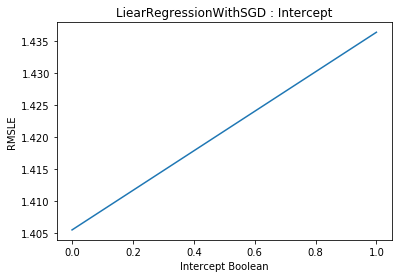

In [29]:
params = [False, True]
metrics = [evaluate(train_data, test_data, 10, 0.1, 1.0, 'l2', param) for param in params]
#metrics = [evaluate(train_data, test_data, 5, 0.1, 1.0, 'l2', param) for param in params]
print (params)
print (metrics)
plot(params, metrics)
fig = matplotlib.pyplot.gcf()
plt.xlabel('Intercept Boolean')
plt.ylabel('RMSLE')
plt.title('LiearRegressionWithSGD : Intercept')

## Iterations

[1, 5, 10, 20, 50, 100]
[2.8895751840351522, 2.0389907666484954, 1.7689106650446305, 1.5672874678333346, 1.4112887844157065, 1.3708564590941776]


Text(0.5,1,'LiearRegressionWithSGD : Iterations')

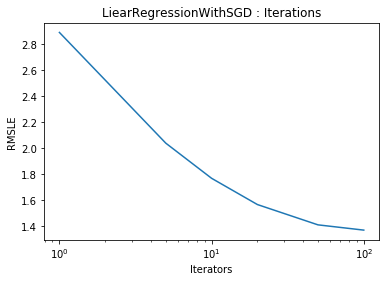

In [30]:
params = [1, 5, 10, 20, 50, 100]
metrics = [evaluate(train_data, test_data, param, 0.01, 0.0, 'l2', False) for param in params]
print (params)
print (metrics)
plot(params, metrics)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')
plt.xlabel('Iterators')
plt.ylabel('RMSLE')
plt.title('LiearRegressionWithSGD : Iterations')

## Step Size

[0.01, 0.025, 0.05, 0.1]
[1.7689106650446305, 1.4109119656546198, 1.37965777743331, 1.4580779096997896]


Text(0.5,1,'LiearRegressionWithSGD : Steps')

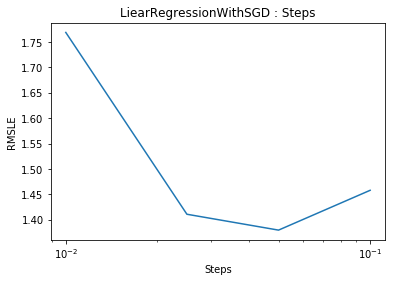

In [31]:
params_step = [0.01, 0.025, 0.05, 0.1]
metrics_step = [evaluate(train_data, test_data, 10, param, 0.0, 'l2', False) for param in params_step]
#metrics_step = [evaluate(train_data, test_data, 5, param, 0.0, 'l2', False) for param in params_step]
print(params_step)
print(metrics_step)
# Plotting
plot(params_step, metrics_step)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')
plt.xlabel('Steps')
plt.ylabel('RMSLE')
plt.title('LiearRegressionWithSGD : Steps')

## L1 Regularization 

[0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
[1.4580779096997896, 1.458043054492044, 1.4577312609446176, 1.4548207151817398, 1.4279738870738146, 1.7425548127469217, 4.775096900108976]


Text(0.5,1,'LiearRegressionWithSGD : L1 Regularization')

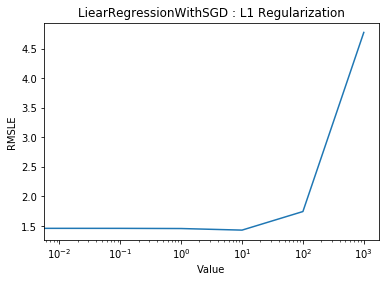

In [32]:
params = [0.0, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
metrics = [evaluate(train_data, test_data, 10, 0.1, param, 'l1', False) for param in params]
#metrics = [evaluate(train_data, test_data, 5, 0.1, param, 'l1', False) for param in params]
print (params)
print (metrics)
plot(params, metrics)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')
plt.xlabel('Value')
plt.ylabel('RMSLE')
plt.title('LiearRegressionWithSGD : L1 Regularization')


## L2 Regularization

[0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
[1.4580779096997896, 1.4574329945186553, 1.4517403325137033, 1.4055537710502843, 1.3809678070431126, 1.5198891882336292, 1.8224536571417238]


Text(0.5,1,'LiearRegressionWithSGD : L2 Regularization')

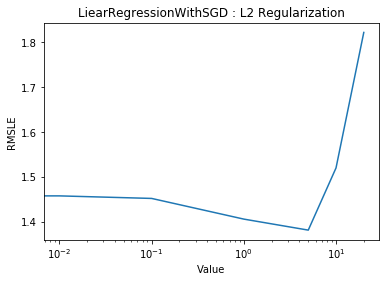

In [33]:

params = [0.0, 0.01, 0.1, 1.0, 5.0, 10.0, 20.0]
metrics = [evaluate(train_data, test_data, 10, 0.1, param, 'l2', False) for param in params]
#metrics = [evaluate(train_data, test_data, 5, 0.1, param, 'l2', False) for param in params]
print (params)
print (metrics)
plot(params, metrics)
fig = matplotlib.pyplot.gcf()
pyplot.xscale('log')
plt.xlabel('Value')
plt.ylabel('RMSLE')
plt.title('LiearRegressionWithSGD : L2 Regularization')

In [34]:
model_l1 = LinearRegressionWithSGD.train(train_data, 10, 0.1, regParam=1.0, regType='l1', intercept=False)
model_l1_10 = LinearRegressionWithSGD.train(train_data, 10, 0.1, regParam=10.0, regType='l1', intercept=False)
model_l1_100 = LinearRegressionWithSGD.train(train_data, 10, 0.1, regParam=100.0, regType='l1', intercept=False)
print ("L1 (1.0) number of zero weights: " + str(sum(model_l1.weights.array == 0)))
print ("L1 (10.0) number of zeros weights: " + str(sum(model_l1_10.weights.array == 0)))
print ("L1 (100.0) number of zeros weights: " + str(sum(model_l1_100.weights.array == 0)))

L1 (1.0) number of zero weights: 5
L1 (10.0) number of zeros weights: 33
L1 (100.0) number of zeros weights: 58


[False, True]
[1.4055537710502843, 1.4363265851099394]


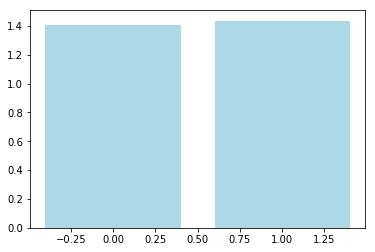

In [35]:
params = [False, True]
metrics = [evaluate(train_data, test_data, 10, 0.1, 1.0, 'l2', param) for param in params]
#metrics = [evaluate(train_data, test_data, 5, 0.1, 1.0, 'l2', param) for param in params]
print (params)
print (metrics)
bar(params, metrics, color='lightblue')
fig = matplotlib.pyplot.gcf()